# Comparison of parameters for jet tagging in fast sim and full sim

Notes: 

- `jet_npfcand` and `jet_nconst` is the same / filled with the same value in full sim


In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_fullsim = "/home/saaumill/FullSimTagger/src/fullsim_tree.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v2/stage2_Hbb.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]

In [3]:
df_fa = tree_fa.arrays(entry_start=0, entry_stop=200, library="np")
df_fu = tree_fu.arrays(entry_start=0, entry_stop=200, library="np")

Check if trees have the same key. Apart from `['event_number','n_hit','n_part']` @Dolores why do we need them when initializing?

In [4]:
list_fu = [item for item in tree_fu.keys() if item not in ['event_number','n_hit','n_part']]

set_fa = set(tree_fa.keys())
set_fu = set(list_fu)

print(set_fa == set_fu)

True


Now let's check if the distributions look the same!

### recojet_isX

In [5]:
len(df_fu['recojet_isB'])

200

In [6]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.set_title(keys[i])
        # set same range if not specified
        try:
            fa = df_fa[keys[i]]
            fu = df_fu[keys[i]]
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        except ValueError:
            fa = np.concatenate(df_fa[keys[i]])
            fu = np.concatenate(df_fu[keys[i]])
            combined_min = min(fa.min(), fu.min())
            combined_max = max(fa.max(), fu.max())
            combined_range = (combined_min, combined_max)
        # plot
        if conc==False:
            ax.hist(df_fa[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(df_fu[keys[i]], bins=bins, range=combined_range, alpha=0.55, label='FullSim')
        else: 
            ax.hist(np.concatenate(df_fa[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FastSim') # set density=True to normalize
            ax.hist(np.concatenate(df_fu[keys[i]]), bins=bins, range=combined_range, alpha=0.55, label='FullSim')
    
    plt.legend()
    plt.tight_layout()

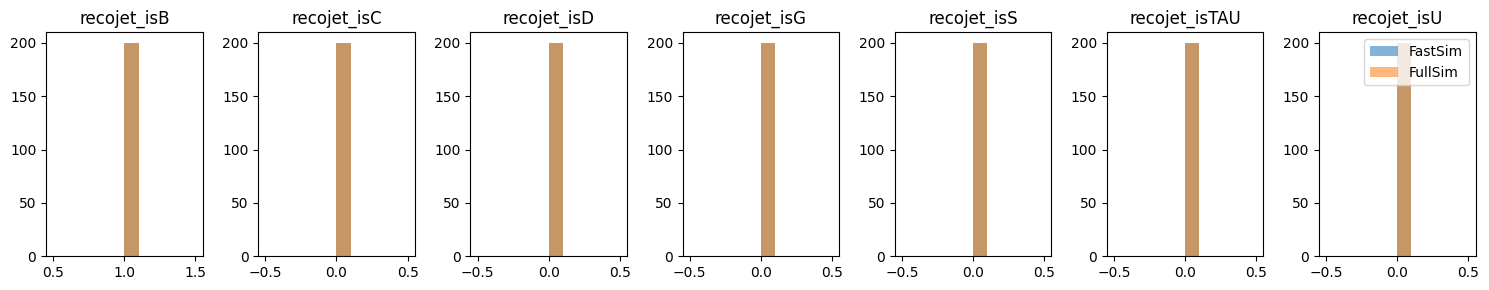

In [7]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

**Conclusion**: we see that in the full sim the reco PID of the quark is wrong! Although we have only b jets it classifies very jet as c ...

Well... not sure that goes wrong here. I definitely use b quarks for fullsim, why is it marked as c? I double checked the PDG IDs.

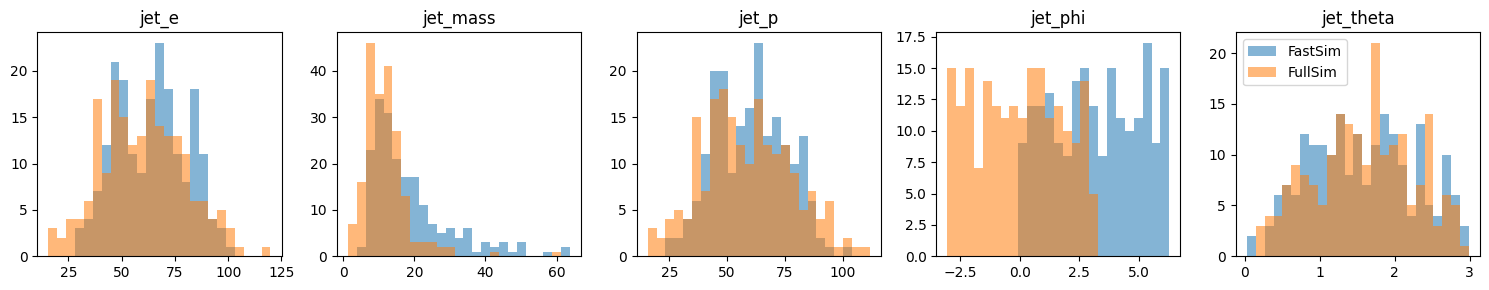

In [8]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25)

- `jet_e` seems fine
- `jet_mass` seems fine
- `jet_p` seems fine
- `jet_phi` seems fine -> only other range! $\phi_{\mathrm{FullSim}} \in [-\pi, \pi]$ but $\phi_{\mathrm{FastSim}} \in [0, 2\pi]$
- `jet_theta` seems fine


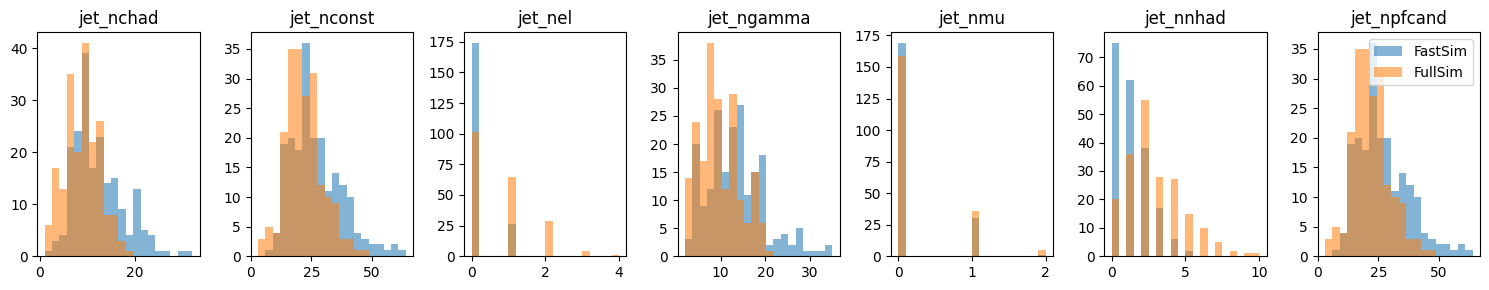

In [9]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20)

Reasonable enough?
-> more neutral hadrons than with fast sim... how I do it is to check for tracks and if no track and no electron or muon its a neutral hadron...

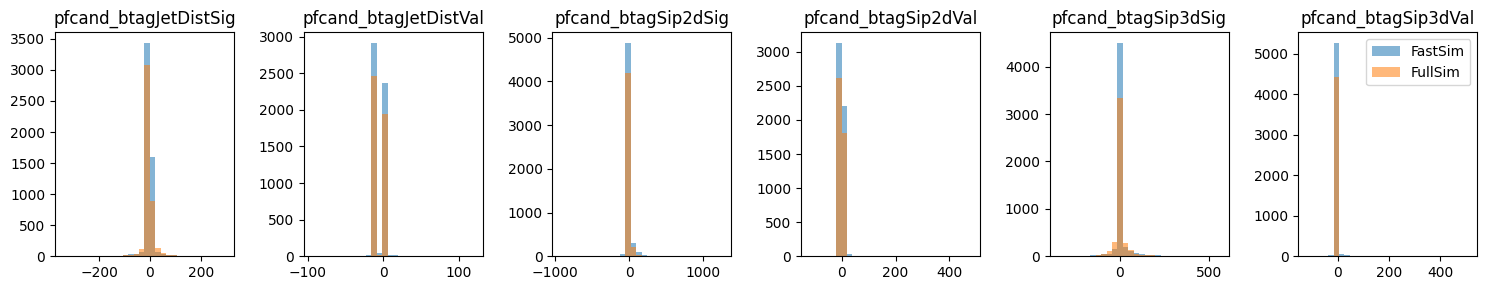

In [32]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

histograms(keys, 1, 6, figsize=(15, 3), bins=30, conc=True)

Okay, Michele said that I should always compare the particles in a jet with the highest amount of energy and not the whole distribution because it might differ in the tails. So let's do that instead:

In [11]:
def get_index_highest_energy_particle(df, k=3, type=211):
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        p_type = np.where(df_fa['pfcand_type'] == type)
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
    index = np.zeros((particles_e.shape[0], k), dtype=int)
    for i, p in enumerate(particles_e[p_type]):
        part_e = particles_e[i]
        ind = np.argpartition(part_e, -k)[-k:]
        ind = ind[np.argsort(part_e[ind])[::-1]]
        index[i] = ind
    return index

In [12]:
index_fa = get_index_highest_energy_particle("fa")
index_fu = get_index_highest_energy_particle("fu")

In [13]:
# Access the desired elements
def get_elements(df_value, index):
    return np.array([df_value[i][index[i]] for i in range(len(df_value))])


In [14]:
def plot_key_highest_e_part(key, k=3, range=None, bins=20):
    fig, axs = plt.subplots(1, k, figsize=(10,3))
    for i, ax in enumerate(axs.flat):
        a = get_elements(df_fa[key], index_fa)[:, i]
        b = get_elements(df_fu[key], index_fu)[:, i]

        if range == None:
            combined_min = min(a.min(), b.min())
            combined_max = max(a.max(), b.max())
            combined_range = (combined_min, combined_max)
        else:
            combined_range = range
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        ax.legend()
        
    plt.show()

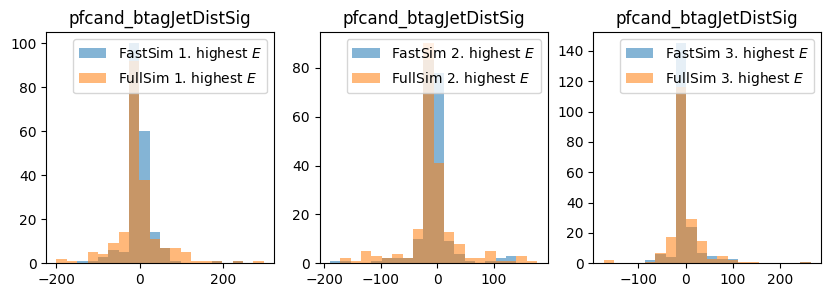

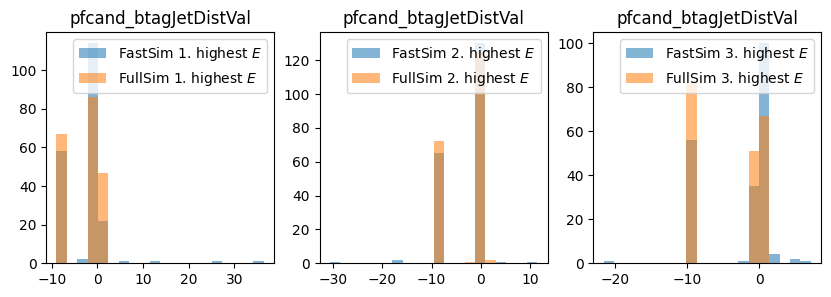

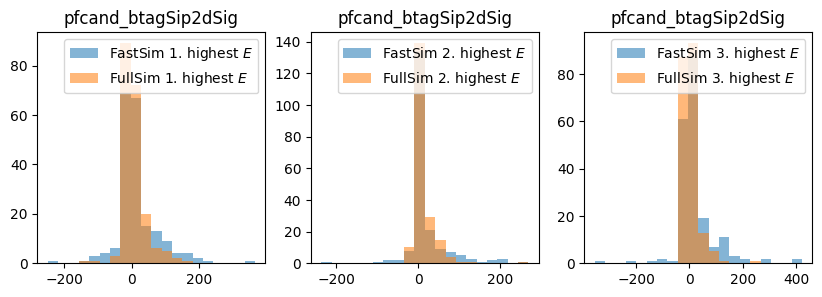

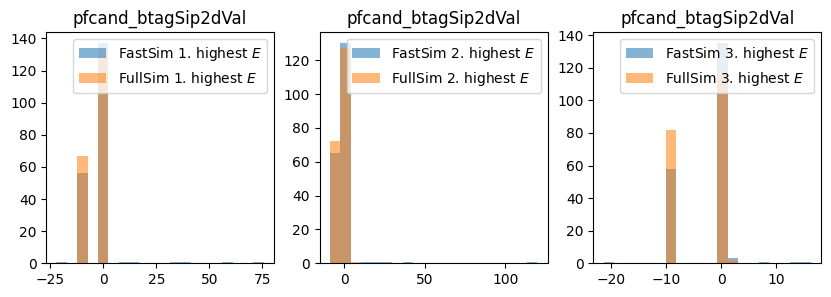

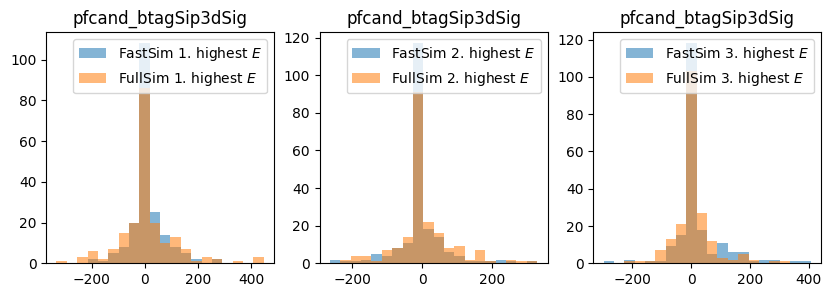

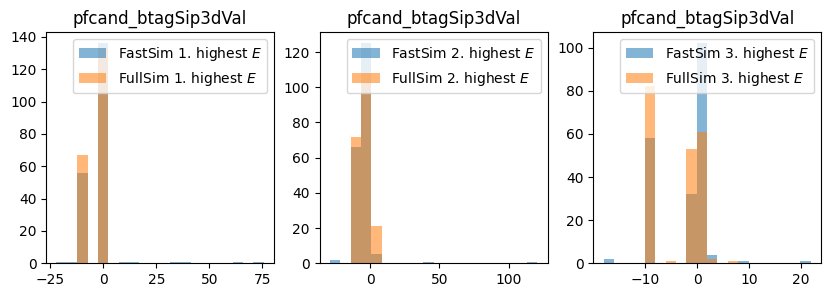

In [15]:
keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

for key in keys:
    plot_key_highest_e_part(key)

Doesn't look too bad I'd say? All the distributions kind of match! Some look a bit different due to the binning but are the same. 

**Watch out**: Setting these values to -9 for neutral tracks makes sense for same values. But for others it doesn't. E.g for 
- SIP3dSig
- SIP2dSig
- JetDistSig 

-> to all the significances it doesn't make sense...

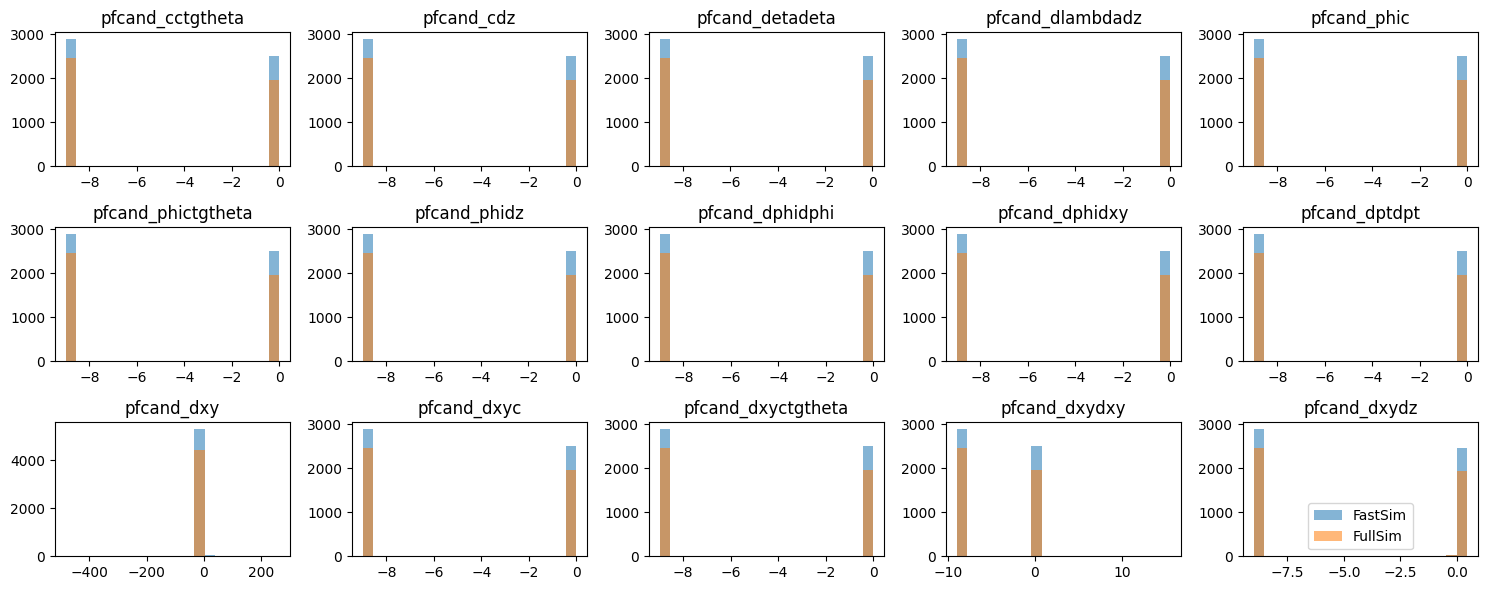

In [16]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']

histograms(keys, 3, 5, figsize=(15, 6), bins=20, conc=True)

Well, we see that at least the -9 makes sense. But let's check for the distributions for the highest energy particles. And cut the region where the -9 is to get a better understanding of the distributions

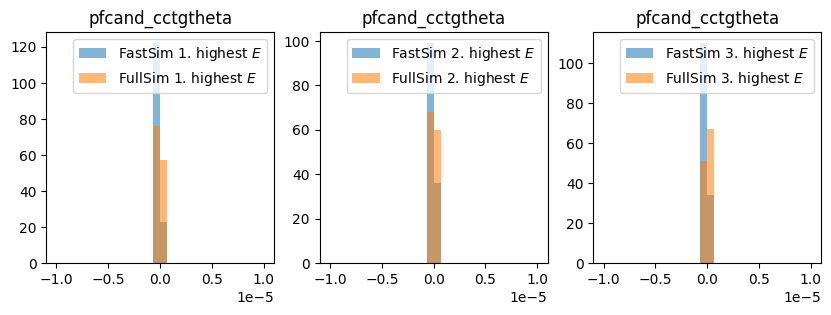

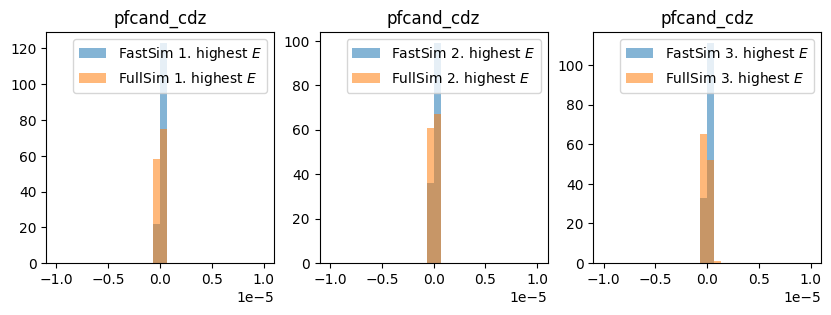

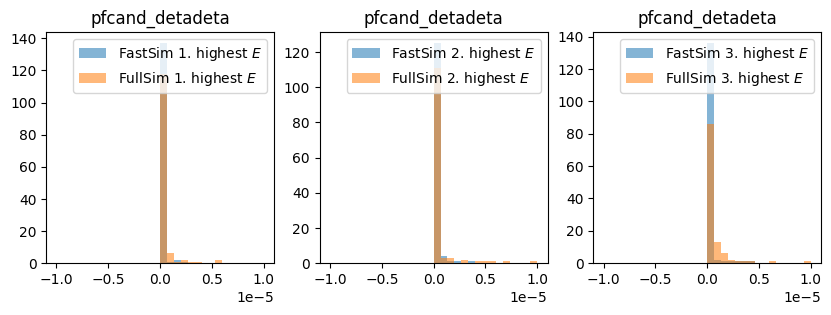

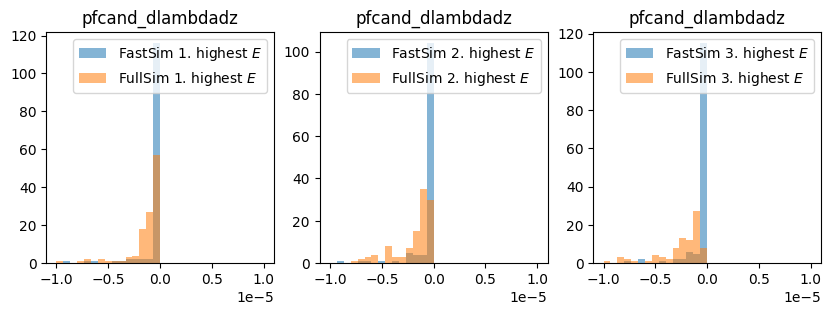

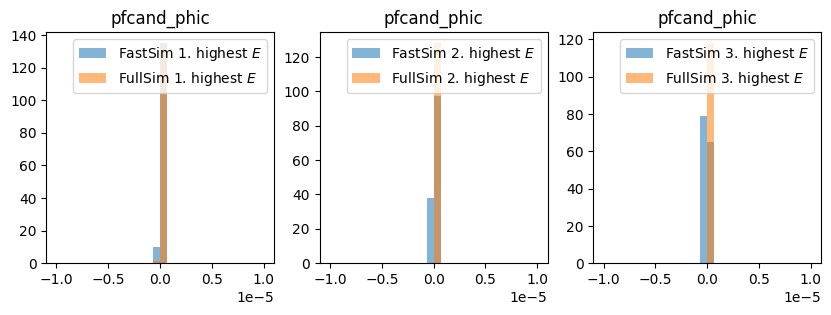

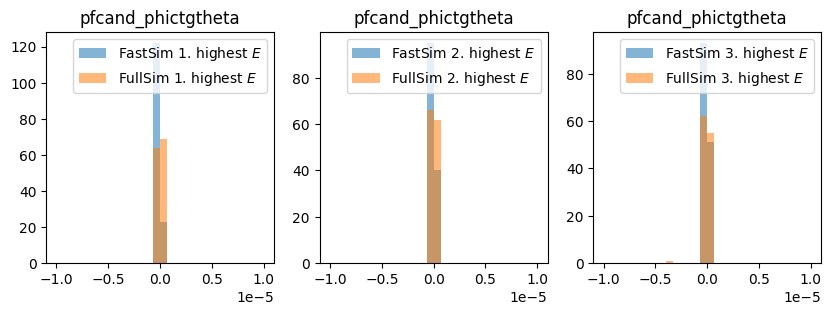

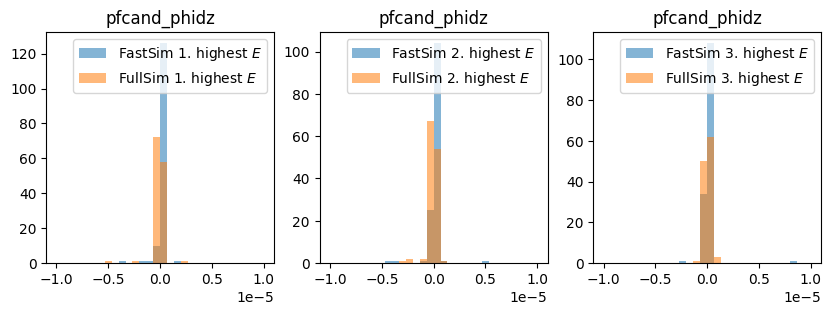

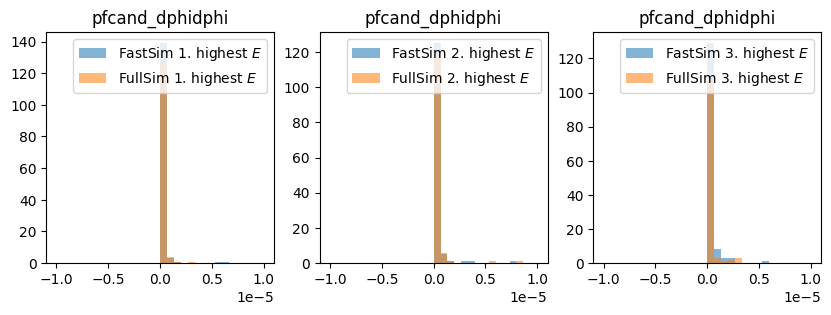

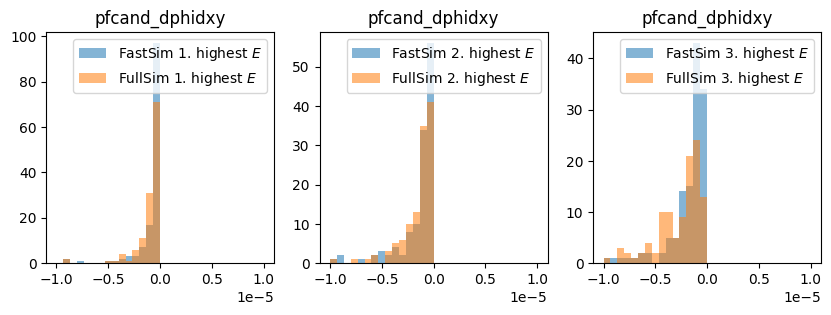

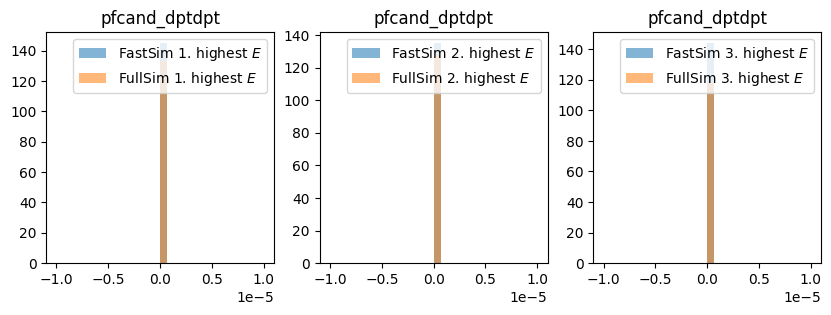

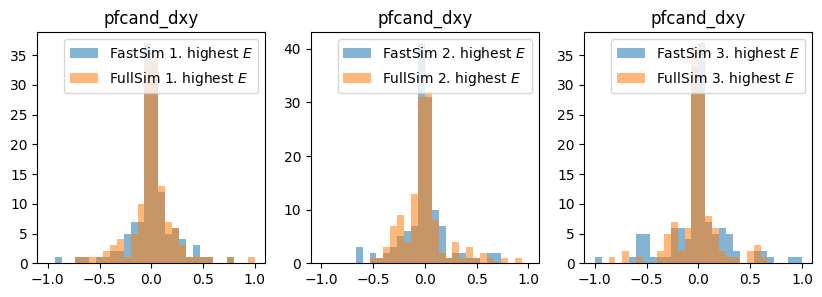

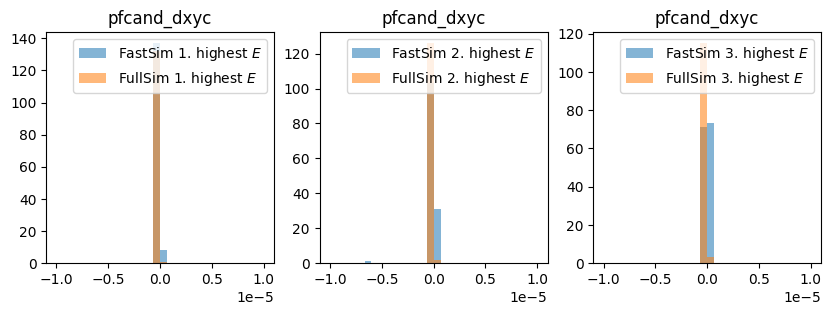

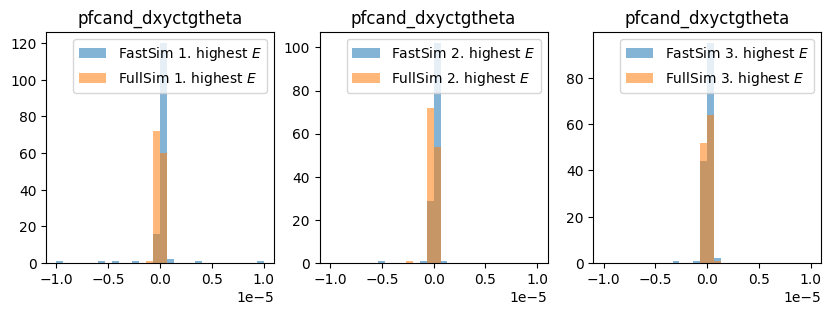

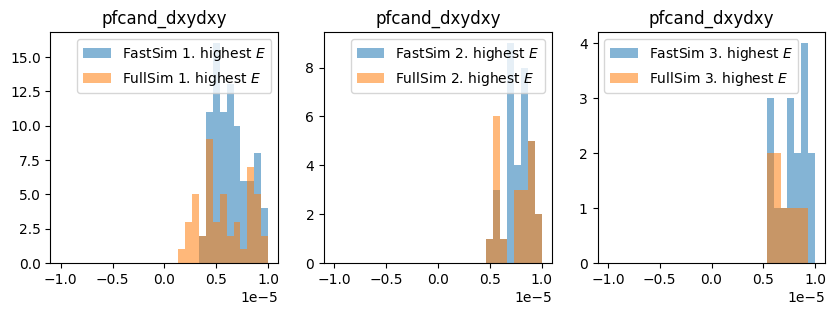

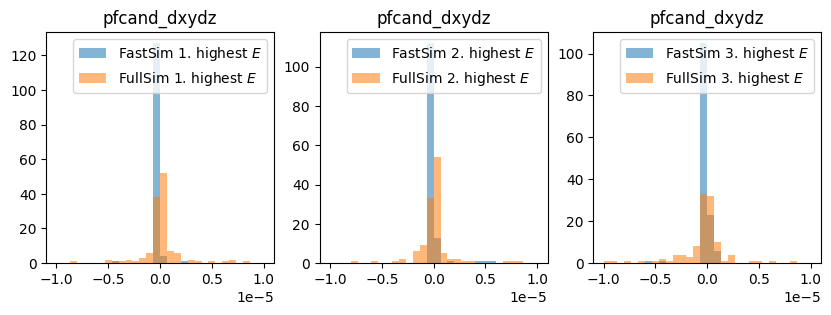

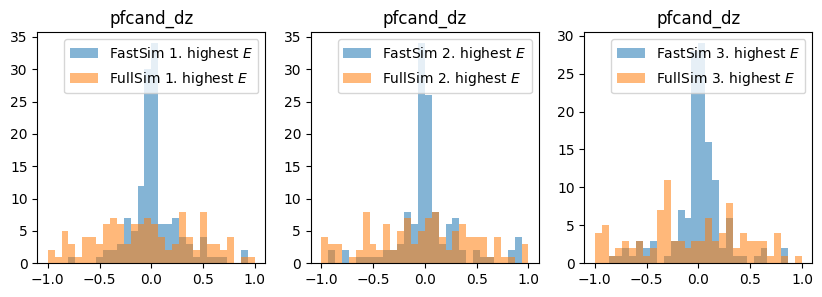

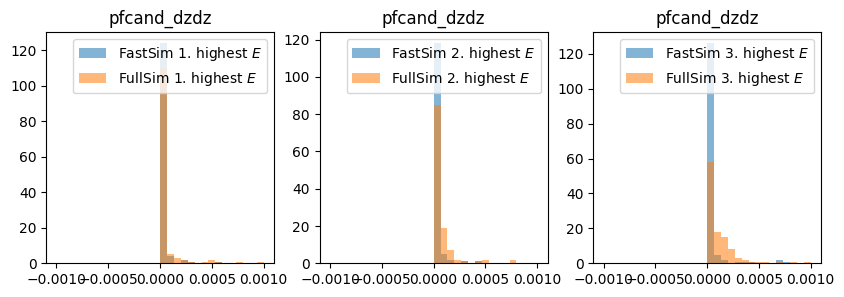

In [17]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']


for key in keys:
    if key in ['pfcand_dxy', 'pfcand_dz']:
        r = [-1,1]
    elif key == "pfcand_dzdz":
        r = [-1e-3, 1e-3]
    else:
        r = [-1e-5, 1e-5]
    plot_key_highest_e_part(key, range=r, bins=30)

In [18]:
def plot_key_highest_e_part_no9(key, k=3, range=None, bins=20):
    fig, axs = plt.subplots(1, k, figsize=(10,3))
    for i, ax in enumerate(axs.flat):

        # filter for charged particles before getting the leading E ones

        a = get_elements(df_fa[key], index_fa)[:, i]
        b = get_elements(df_fu[key], index_fu)[:, i]

        a = a[a != -9]
        b = b[b != -9]

        combined_min = min(a.min(), b.min())
        combined_max = max(a.max(), b.max())
        combined_range = (combined_min, combined_max)
        
        ax.set_title(key)
        ax.hist(a, bins=bins, alpha=0.55, range=combined_range, label=f'FastSim {i+1}'+r'. highest $E$')
        ax.hist(b, bins=bins, alpha=0.55, range=combined_range, label=f'FullSim {i+1}'+r'. highest $E$')
        ax.legend()
        
    plt.show()

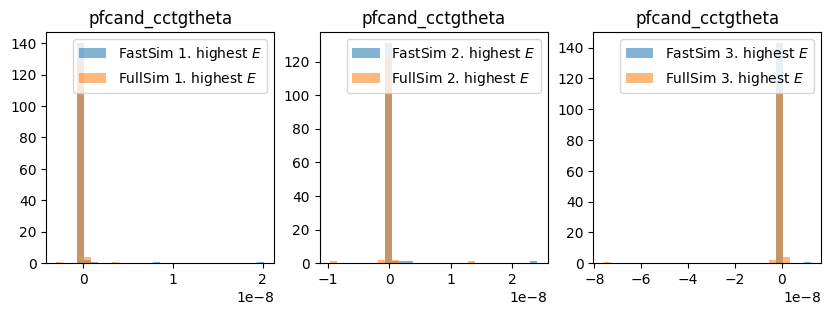

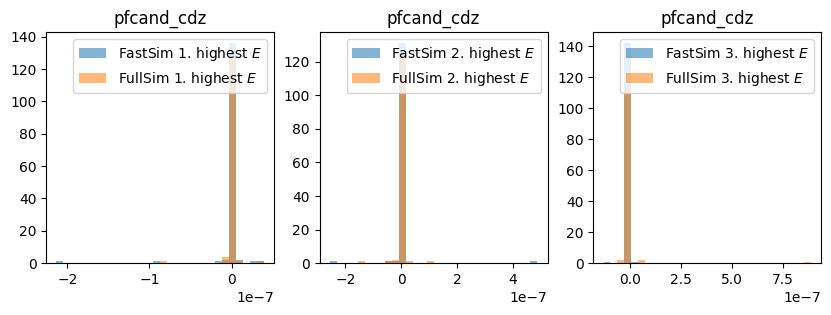

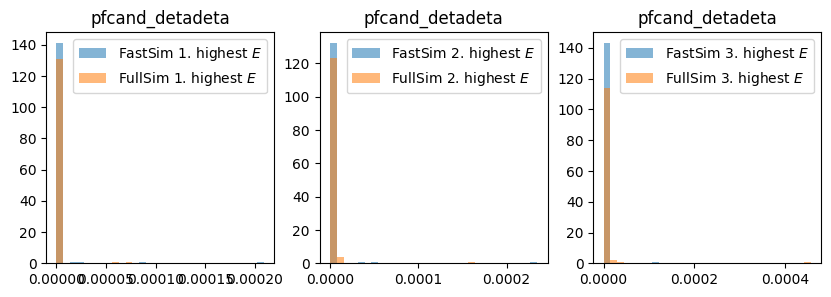

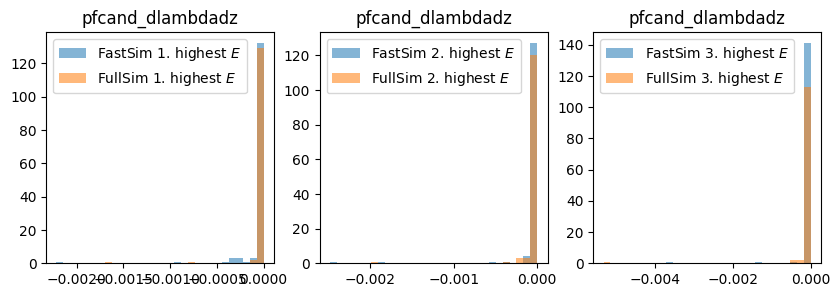

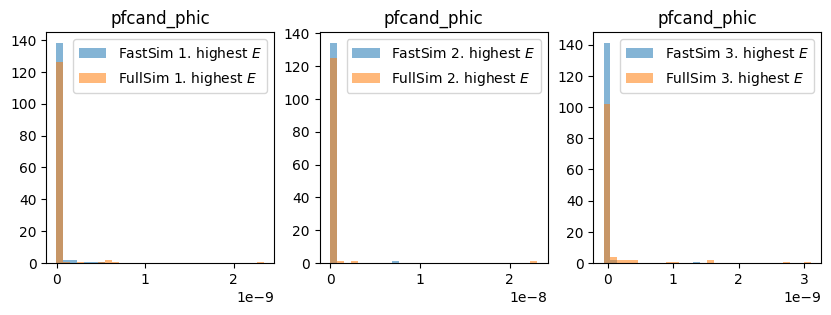

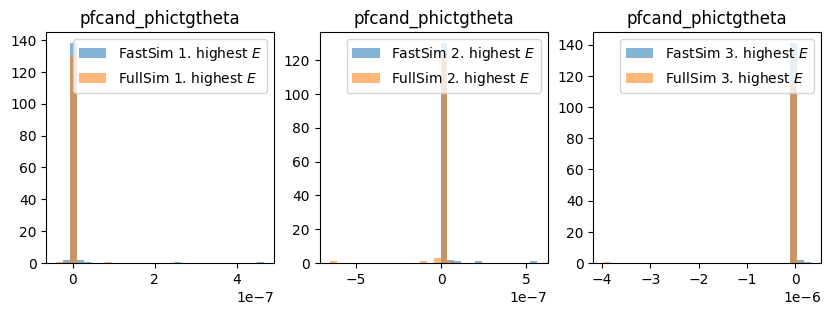

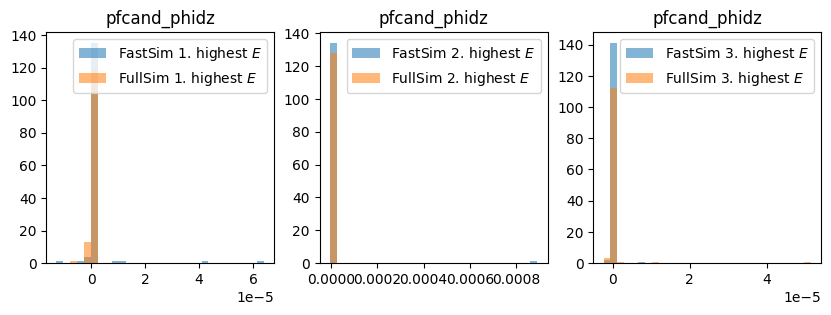

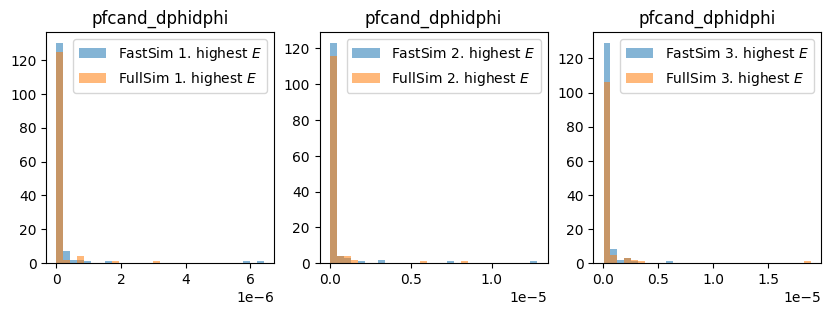

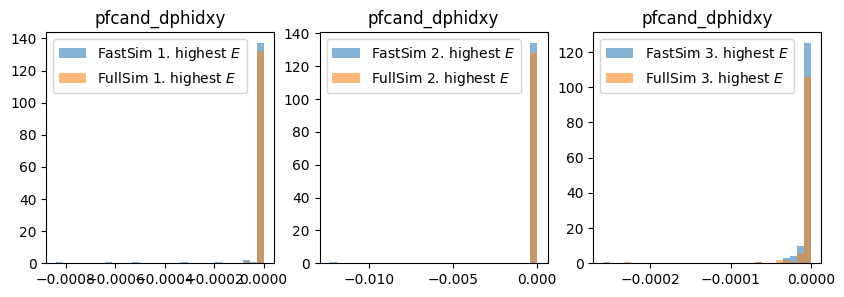

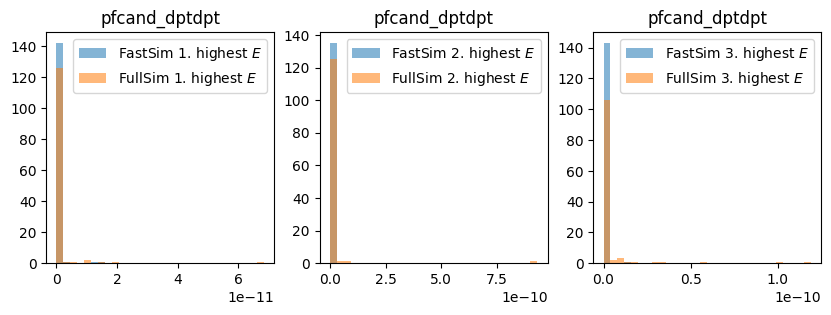

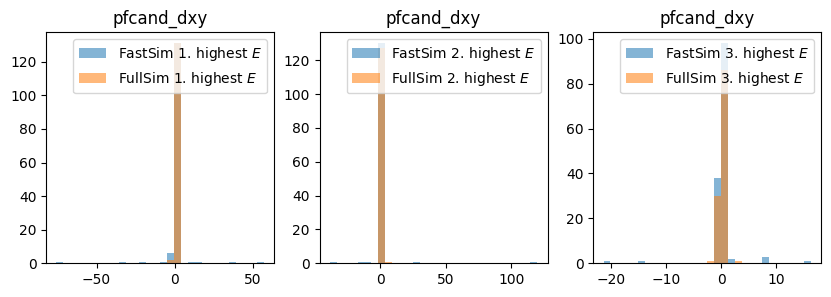

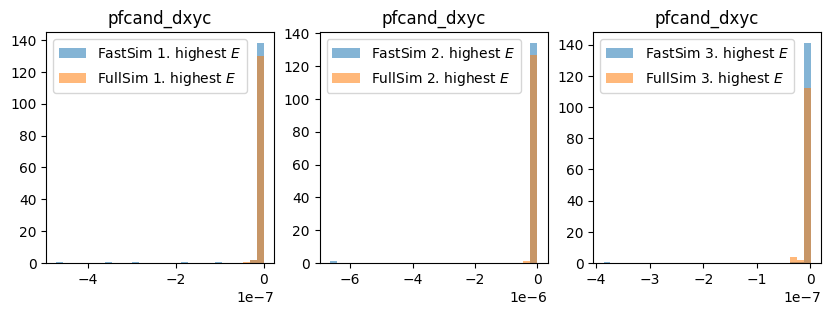

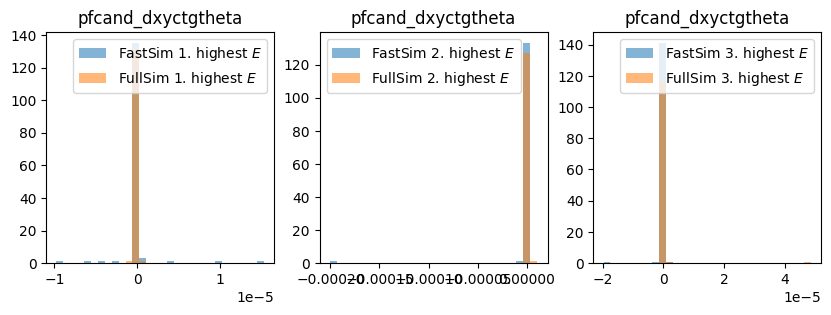

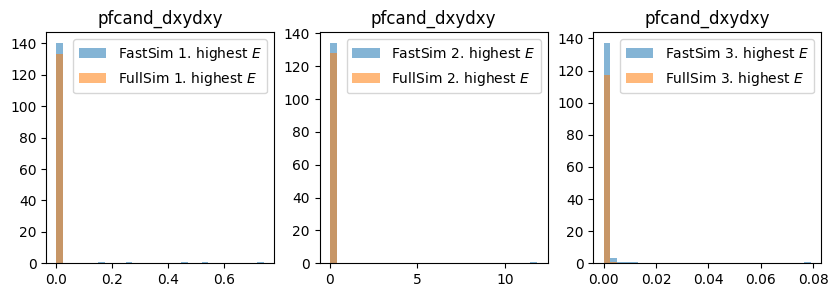

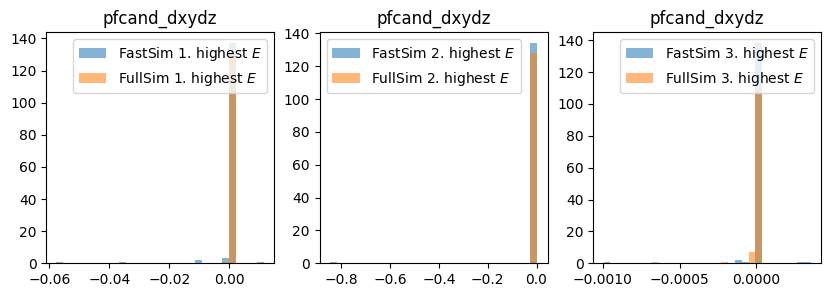

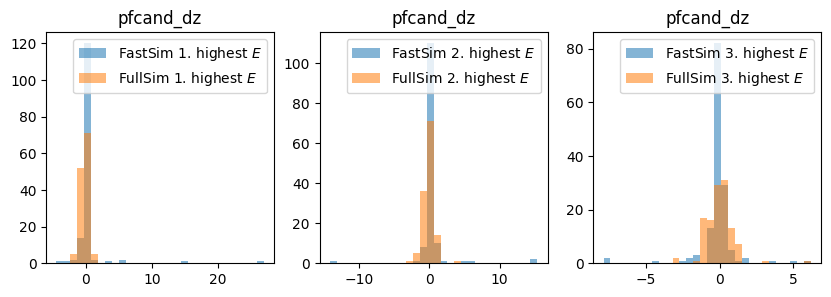

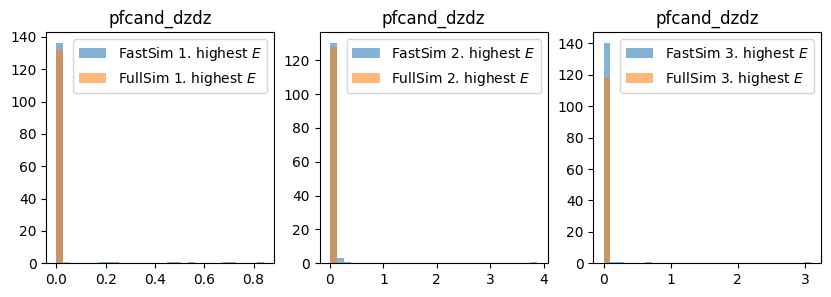

In [19]:
keys = ['pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi',
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxy',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dz',
 'pfcand_dzdz']


for key in keys:
    plot_key_highest_e_part_no9(key, bins=30)

FCCAnalyses https://github.com/HEP-FCC/FCCAnalyses/blob/master/examples/FCCee/weaver/config.py

There are so many outliner, quite hard to compare...

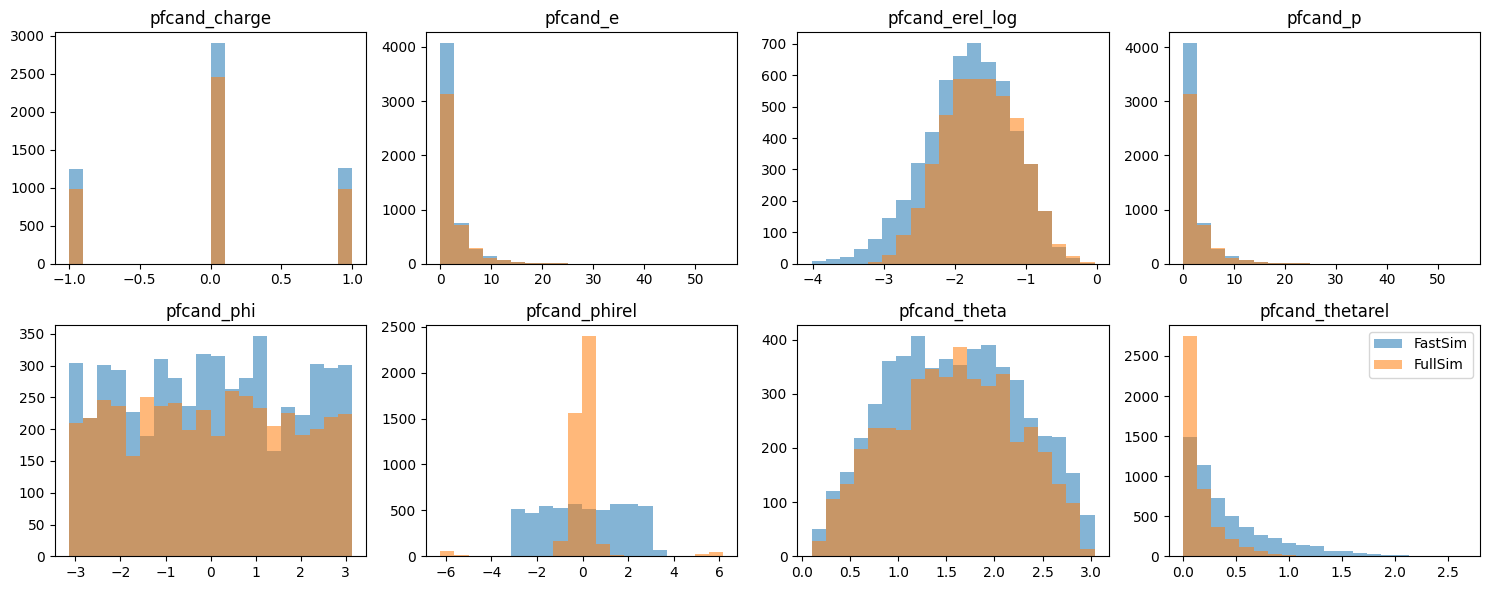

In [20]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

In [21]:
print(df_fa['pfcand_erel_log'].shape)
print(df_fu['pfcand_erel_log'].shape)

(200,)
(200,)


Angles are off... I do not understand what the difference between my method and FCCAnalysis is...

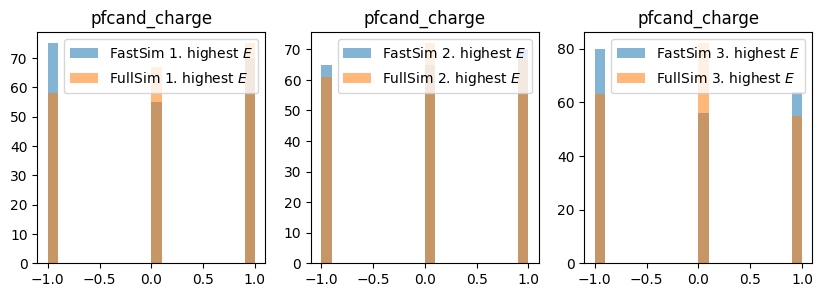

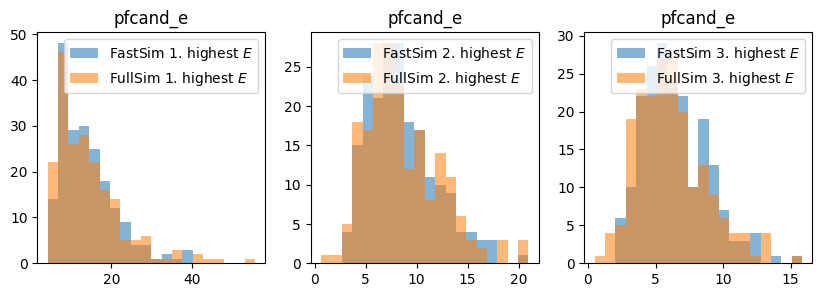

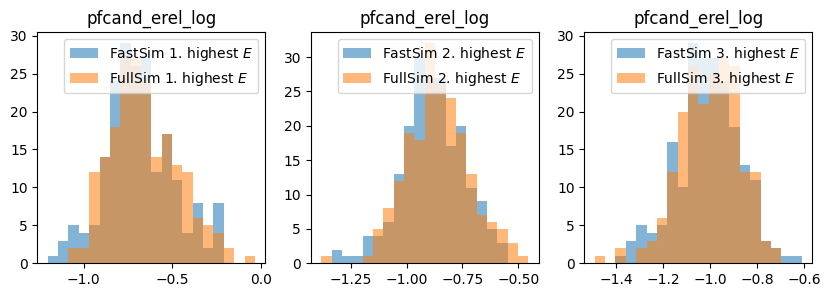

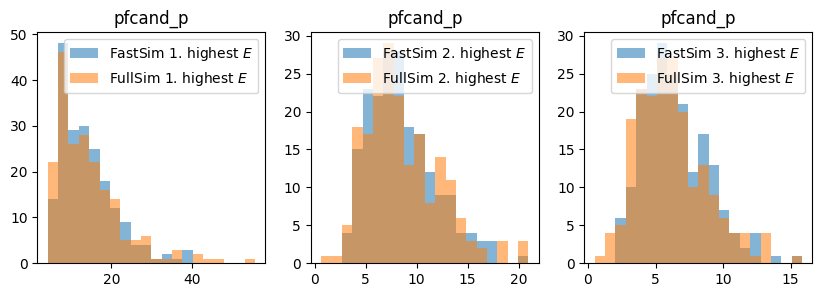

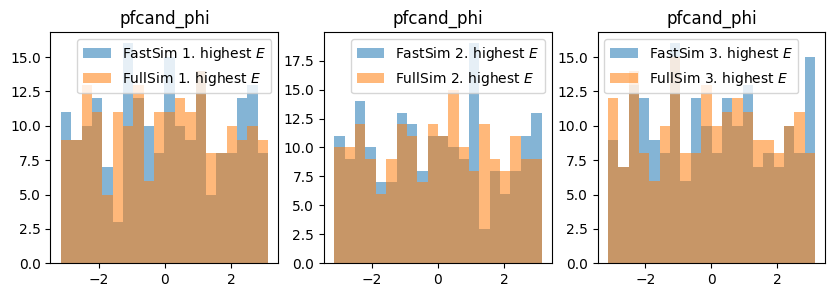

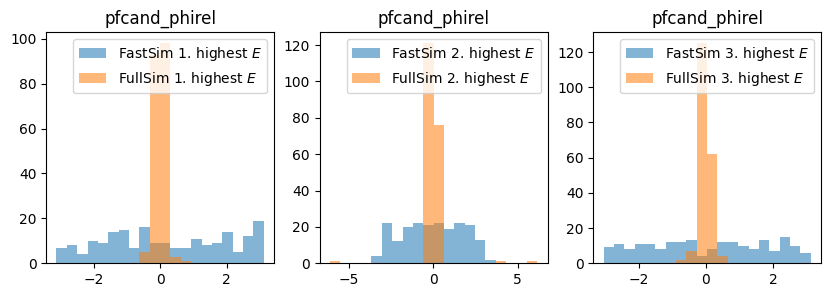

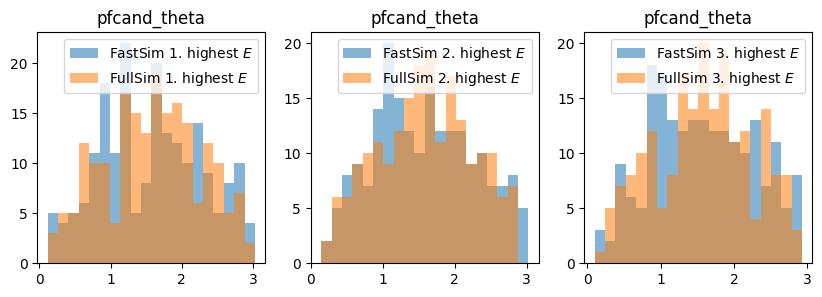

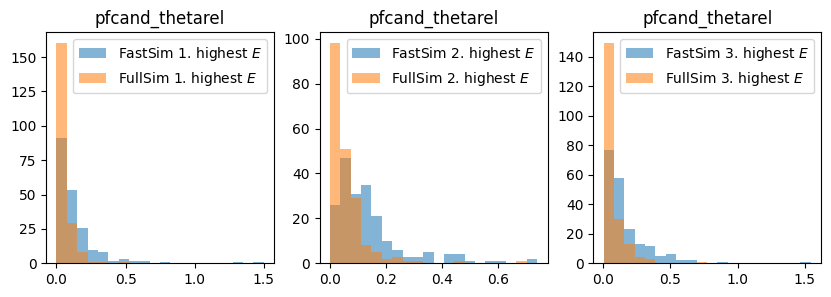

In [22]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

for key in keys:
    plot_key_highest_e_part(key)

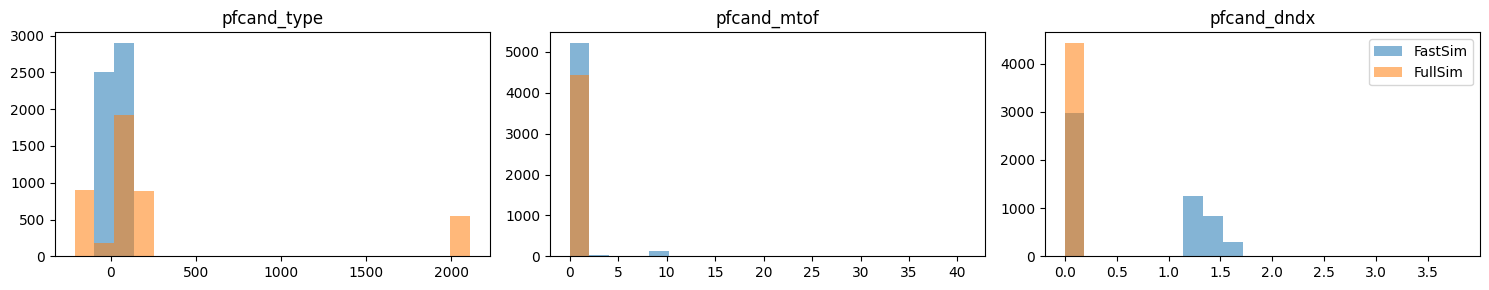

In [23]:
keys = ['pfcand_type', 'pfcand_mtof', 'pfcand_dndx']

histograms(keys, 1, 3, figsize=(15, 3), bins=20, conc=True)

it's normal that `pfcand_mtof` is off and `pfcand_dndx` because it set them to zero. 

But `pfcand_type` not... 

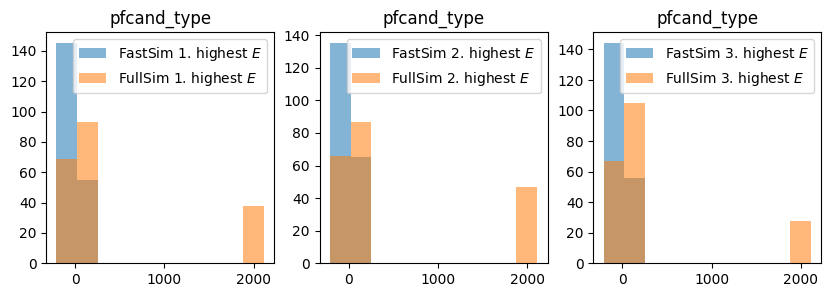

In [24]:
plot_key_highest_e_part('pfcand_type', k=3, bins=10)

In [25]:
from collections import defaultdict

In [26]:
def count_values(arrays, flatten=True):
    count_dict = defaultdict(int)
    
    # Flatten the array of arrays
    if flatten:
        flattened = np.concatenate(arrays)
    else:
        flattened = arrays
    
    # Count each value in the flattened array
    for value in flattened:
        count_dict[value] += 1
    
    return dict(count_dict)

In [27]:
count_values(df_fa['pfcand_type'])

{0.0: 2507, 22.0: 2678, 130.0: 223}

In [28]:
count_values(df_fu['pfcand_type'])

{211: 883, -211: 896, 22: 1921, 2112: 543, 11: 66, -11: 73, 13: 24, -13: 22}

In [29]:
np.sum(df_fu['jet_nnhad']) #543

543

In [30]:
np.sum(df_fu['jet_nchad']) #883 + 896 = 1779 check

1779

Well, we see that we have a lot more particle typed identified in full sim than in fast sim. FastSim has 0 while Fullsim doesn't have that option.

## Open questions
- keys (three more in fullsim - we need them?)
- how to check if tree structure is the same?
- `recojet_isX` is wrong - how to deal with that?
- which values are MC and with one reconstructed?
- SIP sig values:-9 doesn't make sense
- covariance values ok?
- `pfcand_anglerel` are off - why?
- `pfcand_type`: different values and handle 0?